In [1]:
import tweepy
import json
import re
import arrow
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from datetime import datetime
from pytz import timezone
from dateutil.parser import parse
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS
from sklearn.cluster import MiniBatchKMeans
from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering
from sklearn.decomposition import PCA
from sklearn.decomposition import TruncatedSVD
from sklearn.manifold import TSNE
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import davies_bouldin_score

In [2]:
trump = pd.read_csv('trump_rnn.csv')
trump.head()

,id,created_at,source,year,month,day,hour,day_of_week,week,is_reply,...,tb_orientation,tb_explanatory,vd_neg,vd_neu,vd_pos,vd_compound,vd_orientation,k_cluster,a_cluster,orientation
0,1256024228777857025,Fri May 01 00:54:46 +0000 2020,Twitter for iPhone,2020,4,30,20,4,17,False,...,negative,subjective,0.373,0.627,0.000,-0.8786,negative,24,0,negative
1,1256016249169084417,Fri May 01 00:23:04 +0000 2020,Twitter for iPhone,2020,4,30,20,4,17,False,...,positive,subjective,0.205,0.671,0.123,-0.4168,negative,24,0,positive
2,1256013240896835585,Fri May 01 00:11:06 +0000 2020,Twitter for iPhone,2020,4,30,20,4,17,True,...,positive,objective,0.072,0.740,0.189,0.6885,positive,12,0,positive
3,1256013239487549441,Fri May 01 00:11:06 +0000 2020,Twitter for iPhone,2020,4,30,20,4,17,False,...,positive,subjective,0.046,0.640,0.314,0.9439,positive,24,0,positive
4,1255926261068763143,Thu Apr 30 18:25:29 +0000 2020,Twitter for iPhone,2020,4,30,14,4,17,False,...,positive,objective,0.000,1.000,0.000,0.0000,neutral,24,0,positive


# evaluation of RNN against TextBlob and VADER

In [3]:
# vader
orientation = trump[trump['vd_orientation'] != trump['tb_orientation']][['tb_orientation', 'vd_orientation', 'orientation']]
orientation.groupby(['vd_orientation', 'orientation']).size().unstack()

orientation,negative,neutral,positive
vd_orientation,,,
negative,241,92,327
neutral,46,36,100
positive,145,48,447


In [4]:
# textblob
orientation.groupby(['tb_orientation', 'orientation']).size().unstack()

orientation,negative,neutral,positive
tb_orientation,,,
negative,124,19,146
neutral,115,120,379
positive,193,37,349


# overall orientation

### number of tweets

In [40]:
# number of tweets
all_cluster = trump.groupby('orientation')['orientation'].size()
all_cluster.head()

orientation
negative    1277
neutral      442
positive    3020
Name: orientation, dtype: int64

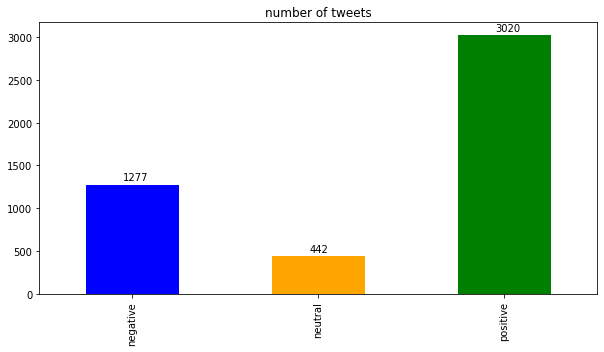

In [41]:
# number of tweets
# more positive tweets than negative tweets
fig, ax = plt.subplots()  
for i, v in enumerate(all_cluster.values):
    ax.text(i-.05, v+50, str(v), color='black')
all_cluster.plot(kind='bar', figsize=(10,5), color=['blue', 'orange', 'green'])
plt.xlabel('')
plt.title('number of tweets')
plt.show()

### retweet_count

In [42]:
# sum of retweet_count
retweet = trump.groupby('orientation')['retweet_count'].sum()
retweet.head()

orientation
negative    27194409.0
neutral      8602356.0
positive    56314509.0
Name: retweet_count, dtype: float64

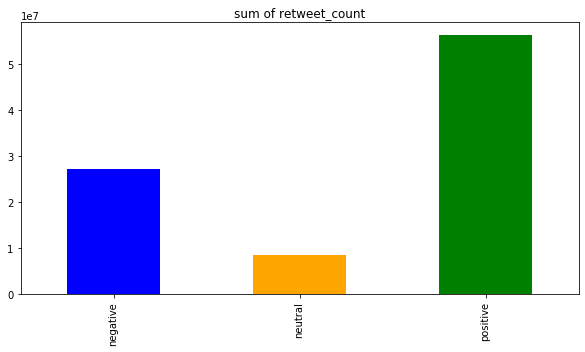

In [43]:
# sum of retweet_count
# similar distribution of number of tweets
retweet.plot(kind='bar', figsize=(10,5), color=['blue', 'orange', 'green'])
plt.xlabel('')
plt.title('sum of retweet_count')
plt.show()

In [44]:
# average retweet_count
retweet = trump.groupby('orientation')['retweet_count'].mean()
retweet.head()

orientation
negative    21295.543461
neutral     19462.343891
positive    18647.188411
Name: retweet_count, dtype: float64

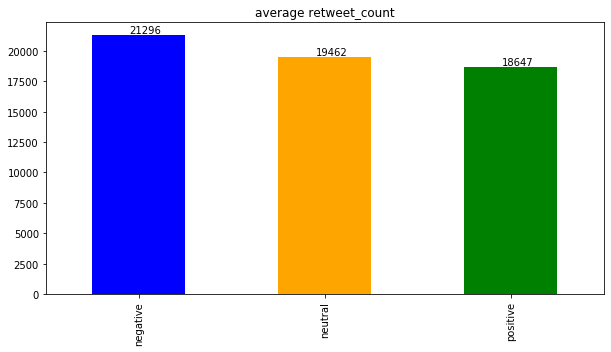

In [45]:
# average retweet_count
# more retweets on trump's negative tweets
# negative > neutral > positive
fig, ax = plt.subplots()  
for i, v in enumerate(retweet.values):
    ax.text(i-.05, v+200, str(int(round(v))), color='black')
retweet.plot(kind='bar', figsize=(10,5), color=['blue', 'orange', 'green'])
plt.xlabel('')
plt.title('average retweet_count')
plt.show()

### favorite_count

In [46]:
# sum of favorite_count
favorite = trump.groupby('orientation')['favorite_count'].sum()
favorite.head()

orientation
negative    116802022.0
neutral      37754296.0
positive    261275343.0
Name: favorite_count, dtype: float64

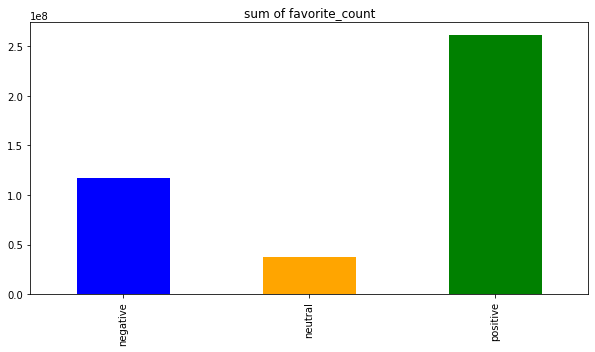

In [47]:
# sum of favorite_count
# similar distribution of number of tweets
favorite.plot(kind='bar', figsize=(10,5), color=['blue', 'orange', 'green'])
plt.xlabel('')
plt.title('sum of favorite_count')
plt.show()

In [48]:
# average favorite_count
favorite = trump.groupby('orientation')['favorite_count'].mean()
favorite.head()

orientation
negative    91465.953015
neutral     85416.959276
positive    86515.014238
Name: favorite_count, dtype: float64

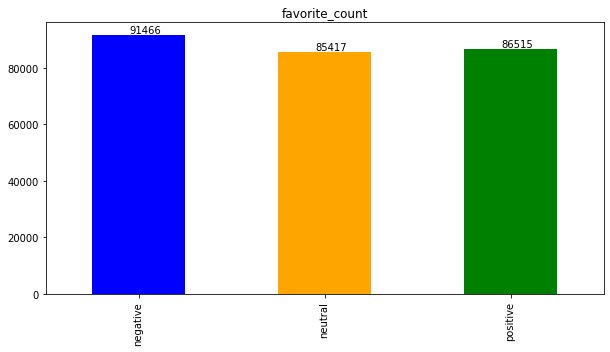

In [49]:
# average favorite_count
# more favorites on trump's negative tweets
# negative > positive > neutral, slightly different from retweet_count
fig, ax = plt.subplots()  
for i, v in enumerate(favorite.values):
    ax.text(i-.05, v+800, str(int(round(v))), color='black')
favorite.plot(kind='bar', figsize=(10,5), color=['blue', 'orange', 'green'])
plt.xlabel('')
plt.title('favorite_count')
plt.show()

# k means

### number of tweets

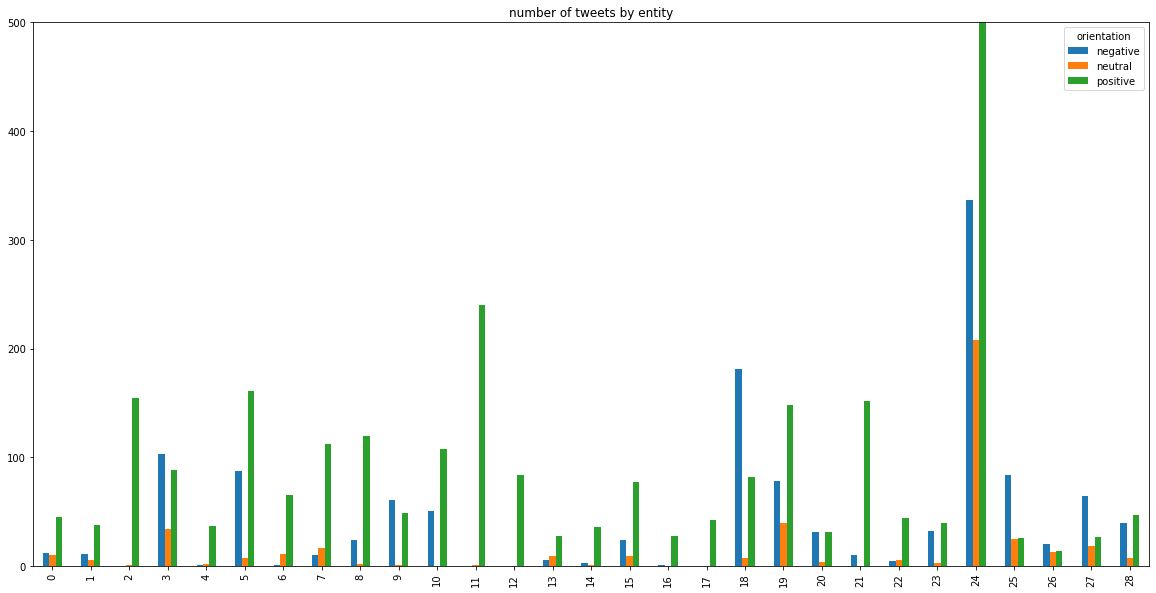

In [99]:
# number of tweets by entity in all clusters
k_cluster = trump[['k_cluster', 'orientation']].groupby(['k_cluster', 'orientation']).size().unstack()
k_cluster.plot(kind='bar', figsize=(20,10), ylim=(0,500))
plt.xlabel('')
plt.title('number of tweets by entity')
plt.show()

In [100]:
# top 8 cluster/entity
top_8 = trump[['k_cluster', 'orientation', 'favorite_count', 'retweet_count']]
top_8 = top_8[top_8['k_cluster'].isin([24, 18, 19, 5, 11, 3, 21, 10])]
top_8['k_cluster'] = top_8['k_cluster'].replace(24, 'Thanks to People').replace(18, 'Fake News')\
                    .replace(19, 'President Trump').replace(5, 'Country').replace(11, 'Great')\
                    .replace(3, 'Democratic Party').replace(21, 'Good').replace(10, 'New York')
top_8.columns = ['entity', 'orientation', 'favorite_count', 'retweet_count']
top_8.head()

,entity,orientation,favorite_count,retweet_count
0,Thanks to People,negative,156126.0,38037.0
1,Thanks to People,positive,34845.0,11170.0
3,Thanks to People,positive,56133.0,13626.0
4,Thanks to People,positive,65073.0,16955.0
5,Fake News,negative,205345.0,45115.0


In [101]:
# number of tweets
count = top_8.rename(columns={'entity':'Topic', 'orientation':'Orientation'}).groupby(['Topic', 'Orientation']).size().unstack()
count = count.fillna(0)
count


Orientation,negative,neutral,positive
Topic,,,
Country,87.0,7.0,161.0
Democratic Party,103.0,34.0,88.0
Fake News,181.0,7.0,82.0
Good,10.0,0.0,152.0
Great,0.0,1.0,240.0
New York,51.0,0.0,108.0
President Trump,78.0,40.0,148.0
Thanks to People,337.0,208.0,896.0


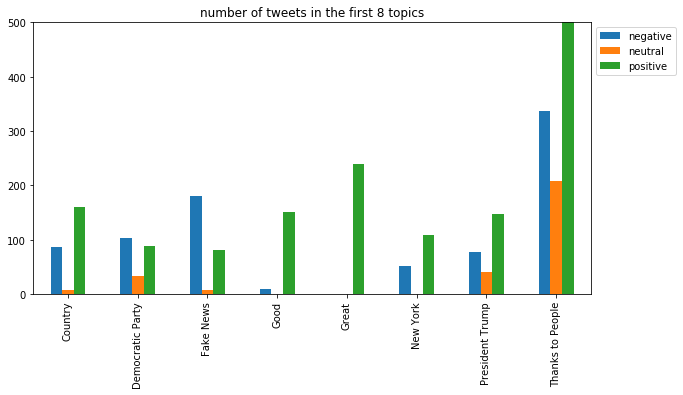

In [102]:
# number of tweets
# more negative tweets on Fake News / Democratic Party
count.plot(kind='bar', figsize=(10,5), ylim=(0,500))
plt.xlabel('')
plt.title('number of tweets in the first 8 topics')
plt.legend(bbox_to_anchor=(1,1), loc="upper left")
plt.show()

### retweet_count

In [103]:
# sum of retweet_count
retweet = top_8.groupby(['entity', 'orientation'])['retweet_count'].sum().unstack()
retweet

orientation,negative,neutral,positive
entity,,,
Country,1791733.0,137952.0,3232149.0
Democratic Party,2112630.0,616832.0,1760591.0
Fake News,4159240.0,116119.0,1585295.0
Good,199226.0,NaN,2723800.0
Great,NaN,3591.0,3324091.0
New York,1015110.0,NaN,1948229.0
President Trump,1591374.0,665310.0,2631755.0
Thanks to People,7269560.0,4080378.0,18050337.0


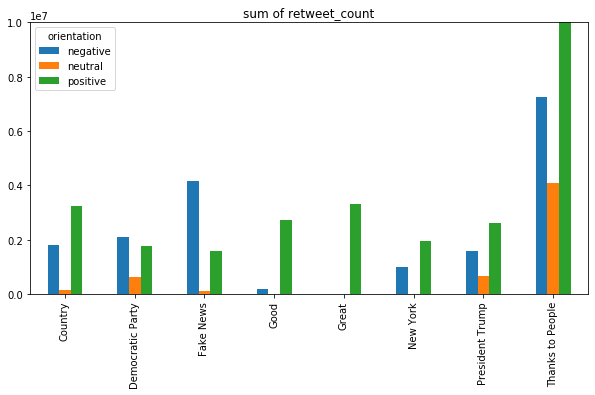

In [104]:
# sum of retweet_count
# similar distribution of number of tweets
retweet.plot(kind='bar', figsize=(10, 5), ylim=(0,1e7))
plt.xlabel('')
plt.title('sum of retweet_count')
plt.show()

In [105]:
# average of retweet_count
retweet = top_8.groupby(['entity', 'orientation'])['retweet_count'].mean().unstack()
retweet

orientation,negative,neutral,positive
entity,,,
Country,20594.632184,19707.428571,20075.459627
Democratic Party,20510.970874,18142.117647,20006.715909
Fake News,22979.226519,16588.428571,19332.865854
Good,19922.600000,NaN,17919.736842
Great,NaN,3591.000000,13850.379167
New York,19904.117647,NaN,18039.157407
President Trump,20402.230769,16632.750000,17782.128378
Thanks to People,21571.394659,19617.201923,20145.465402


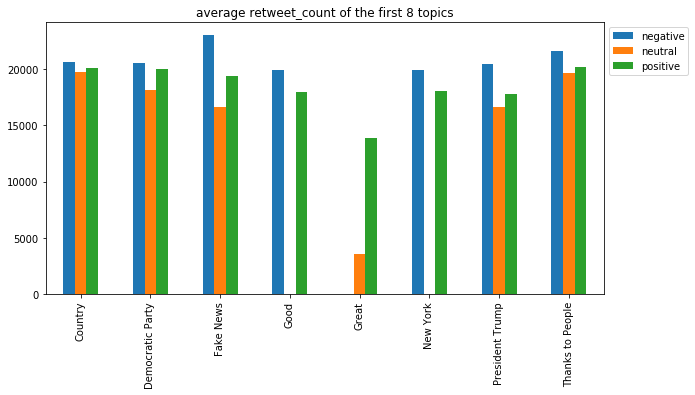

In [106]:
# average of retweet_count
# positive: Great
# all others are about negative tweets
retweet.plot(kind='bar', figsize=(10, 5))
plt.xlabel('')
plt.title('average retweet_count of the first 8 topics')
plt.legend(bbox_to_anchor=(1,1), loc="upper left")
plt.show()

### favorite_count

In [107]:
# sum of favorite_count
favorite = top_8.groupby(['entity', 'orientation'])['favorite_count'].sum().unstack()
favorite

orientation,negative,neutral,positive
entity,,,
Country,7776896.0,689020.0,15221724.0
Democratic Party,8974588.0,2403340.0,7665873.0
Fake News,17688653.0,577428.0,7607673.0
Good,849875.0,NaN,12842438.0
Great,NaN,18091.0,16200424.0
New York,4483204.0,NaN,8907817.0
President Trump,6762902.0,2806257.0,11808563.0
Thanks to People,31621271.0,18278129.0,82435475.0


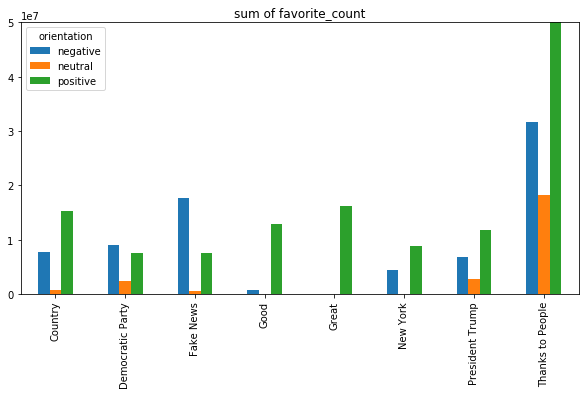

In [108]:
# sum of favorite_count
# similar distribution of number of tweets
favorite.plot(kind='bar', figsize=(10, 5), ylim=(0,5e7))
plt.xlabel('')
plt.title('sum of favorite_count')
plt.show()

In [109]:
# average of favorite_count
favorite = top_8.groupby(['entity', 'orientation'])['favorite_count'].mean().unstack()
favorite

orientation,negative,neutral,positive
entity,,,
Country,89389.609195,98431.428571,94544.869565
Democratic Party,87131.922330,70686.470588,87112.193182
Fake News,97727.364641,82489.714286,92776.500000
Good,84987.500000,NaN,84489.723684
Great,NaN,18091.000000,67501.766667
New York,87905.960784,NaN,82479.787037
President Trump,86703.871795,70156.425000,79787.587838
Thanks to People,93831.664688,87875.620192,92003.878348


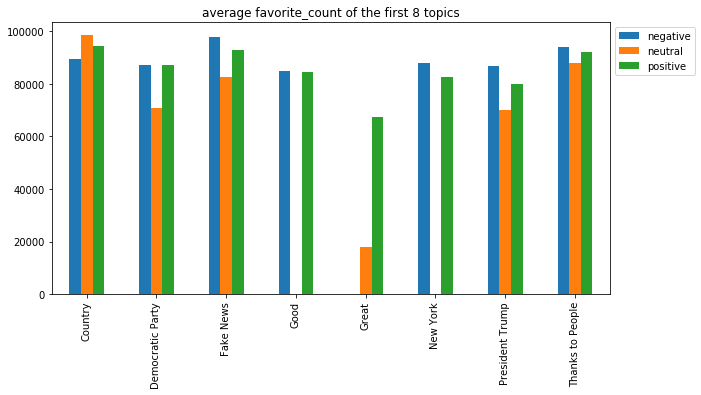

In [110]:
# average of favorite_count
# neutral: Country
# positive: Great
# all others are about negative tweets
favorite.plot(kind='bar', figsize=(10, 5))
plt.xlabel('')
plt.title('average favorite_count of the first 8 topics')
plt.legend(bbox_to_anchor=(1,1), loc="upper left")
plt.show()

# hierarchical clustering

### number of tweets

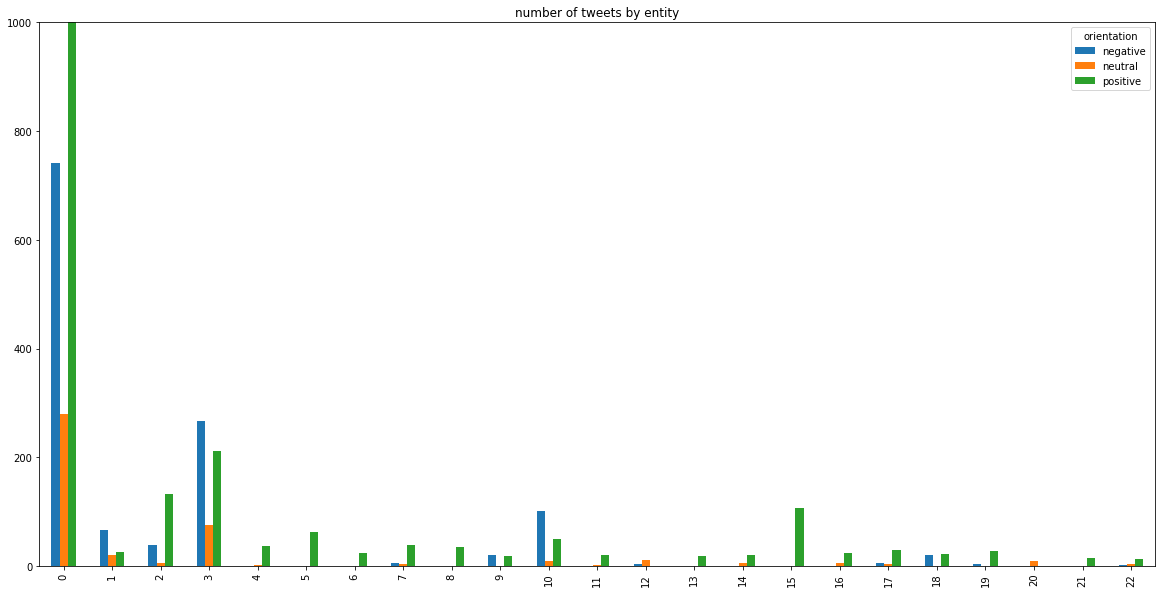

In [111]:
# number of tweets by entity in all clusters
a_cluster = trump[['a_cluster', 'orientation']].groupby(['a_cluster', 'orientation']).size().unstack()
a_cluster.plot(kind='bar', figsize=(20,10), ylim=(0,1000))
plt.xlabel('')
plt.title('number of tweets by entity')
plt.show()

In [112]:
top_8 = trump[['a_cluster', 'orientation', 'favorite_count', 'retweet_count']]
top_8 = top_8[top_8['a_cluster'].isin([0, 1, 2, 3, 10, 15, 5, 7])]
top_8['a_cluster'] = top_8['a_cluster'].replace(0, 'Thanks to People').replace(1, 'Whistleblower').replace(2, 'China')\
                    .replace(3, 'Democratic Party').replace(10, 'Fake News')\
                    .replace(15, 'Thanks').replace(5, 'Endorsement').replace(7, 'North Carolina')
top_8.columns = ['entity', 'orientation', 'favorite_count', 'retweet_count']
top_8.head()

,entity,orientation,favorite_count,retweet_count
0,Thanks to People,negative,156126.0,38037.0
1,Thanks to People,positive,34845.0,11170.0
2,Thanks to People,positive,33328.0,8521.0
3,Thanks to People,positive,56133.0,13626.0
4,Thanks to People,positive,65073.0,16955.0


In [113]:
# number of tweets
count = top_8.rename(columns={'entity':'Topic', 'orientation':'Orientation'}).groupby(['Topic', 'Orientation']).size().unstack()
count = count.fillna(0)
count


Orientation,negative,neutral,positive
Topic,,,
China,38.0,5.0,132.0
Democratic Party,267.0,76.0,211.0
Endorsement,0.0,0.0,63.0
Fake News,102.0,10.0,49.0
North Carolina,5.0,4.0,38.0
Thanks,0.0,0.0,106.0
Thanks to People,742.0,280.0,2088.0
Whistleblower,67.0,21.0,26.0


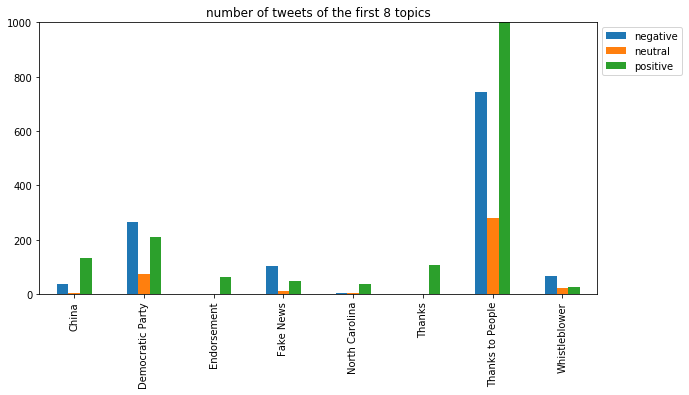

In [114]:
# tweet count
# negative: Democratic Party, Fake News, Whistleblower
# all others are about positive tweets
count.plot(kind='bar', figsize=(10,5), ylim=(0,1000))
plt.xlabel('')
plt.title('number of tweets of the first 8 topics')
plt.legend(bbox_to_anchor=(1,1), loc="upper left")
plt.show()

### retweet_count

In [115]:
# sum of retweet_count
retweet = top_8.groupby(['entity', 'orientation'])['retweet_count'].sum().unstack()
retweet

orientation,negative,neutral,positive
entity,,,
China,580888.0,108102.0,2162074.0
Democratic Party,5474385.0,1370405.0,4013697.0
Endorsement,NaN,NaN,682858.0
Fake News,2212526.0,98982.0,944840.0
North Carolina,79281.0,44380.0,464504.0
Thanks,NaN,NaN,1446345.0
Thanks to People,16356694.0,5688128.0,40543450.0
Whistleblower,1515568.0,405982.0,493598.0


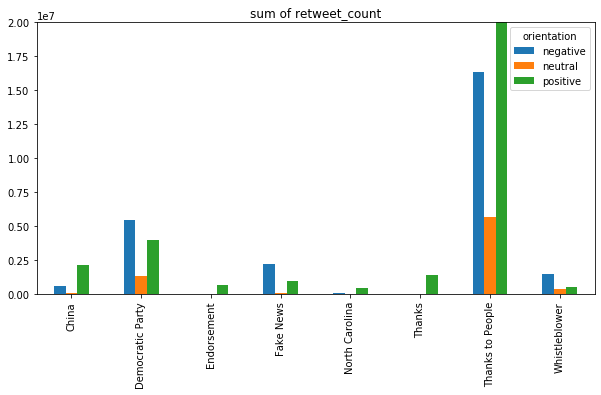

In [116]:
# sum of retweet_count
# similar distribution 
retweet.plot(kind='bar', figsize=(10, 5), ylim=(0, 2e7))
plt.xlabel('')
plt.title('sum of retweet_count')
plt.show()

In [117]:
# average of retweet_count
retweet = top_8.groupby(['entity', 'orientation'])['retweet_count'].mean().unstack()
retweet

orientation,negative,neutral,positive
entity,,,
China,15286.526316,21620.400000,16379.348485
Democratic Party,20503.314607,18031.644737,19022.260664
Endorsement,NaN,NaN,10839.015873
Fake News,21691.431373,9898.200000,19282.448980
North Carolina,15856.200000,11095.000000,12223.789474
Thanks,NaN,NaN,13644.764151
Thanks to People,22044.061995,20314.742857,19417.361111
Whistleblower,22620.417910,19332.476190,18984.538462


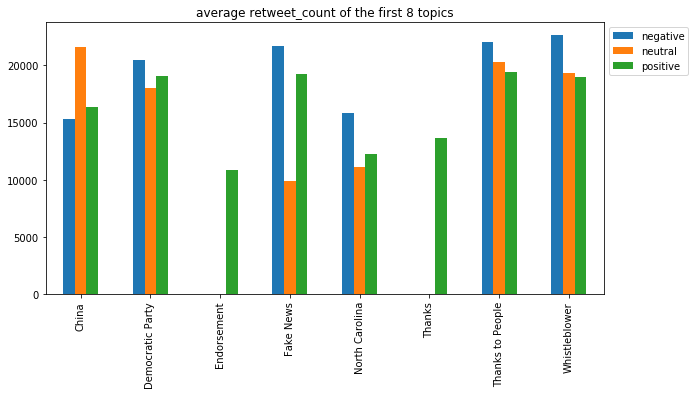

In [118]:
# average of retweet_count
# neutral: China
# positive: Endorsement, Thanks
# all others are about negative tweets
retweet.plot(kind='bar', figsize=(10, 5))
plt.xlabel('')
plt.title('average retweet_count of the first 8 topics')
plt.legend(bbox_to_anchor=(1,1), loc="upper left")
plt.show()

### favorite_count

In [119]:
# sum of favorite_count
favorite = top_8.groupby(['entity', 'orientation'])['favorite_count'].sum().unstack()
favorite

orientation,negative,neutral,positive
entity,,,
China,2527688.0,494077.0,10243552.0
Democratic Party,23330259.0,5475775.0,17497371.0
Endorsement,NaN,NaN,2592410.0
Fake News,9324803.0,383005.0,4180492.0
North Carolina,330859.0,239529.0,2084882.0
Thanks,NaN,NaN,6350417.0
Thanks to People,70718519.0,25115046.0,187492570.0
Whistleblower,6166841.0,1576506.0,2024873.0


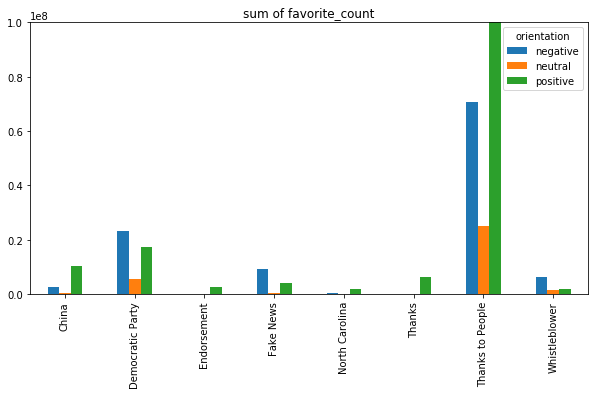

In [120]:
# sum of favorite_count
# similar distribution of number of tweets
favorite.plot(kind='bar', figsize=(10, 5), ylim=(0, 1e8))
plt.xlabel('')
plt.title('sum of favorite_count')
plt.show()

In [121]:
# average of favorite_count
favorite = top_8.groupby(['entity', 'orientation'])['favorite_count'].mean().unstack()
favorite

orientation,negative,neutral,positive
entity,,,
China,66518.105263,98815.400000,77602.666667
Democratic Party,87379.247191,72049.671053,82925.928910
Endorsement,NaN,NaN,41149.365079
Fake News,91419.637255,38300.500000,85316.163265
North Carolina,66171.800000,59882.250000,54865.315789
Thanks,NaN,NaN,59909.594340
Thanks to People,95307.977089,89696.592857,89795.292146
Whistleblower,92042.402985,75071.714286,77879.730769


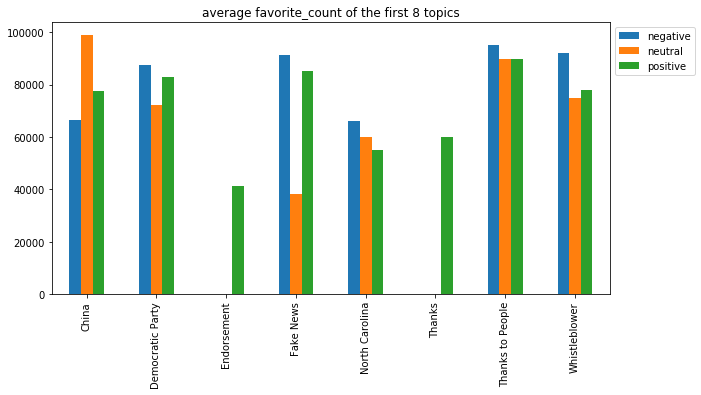

In [122]:
# average of favorite_count
# neutral: China
# positive: Endorsement, Thanks
# all others are about negative tweets
favorite.plot(kind='bar', figsize=(10, 5))
plt.xlabel('')
plt.title('average favorite_count of the first 8 topics')
plt.legend(bbox_to_anchor=(1,1), loc="upper left")
plt.show()

# time

### number of tweets

In [123]:
# trump's orientation against hour
hour = trump.groupby(['hour', 'orientation']).size().unstack()
hour

orientation,negative,neutral,positive
hour,,,
0,35.0,14.0,74.0
1,7.0,5.0,22.0
2,2.0,NaN,5.0
3,1.0,1.0,6.0
4,4.0,1.0,9.0
5,5.0,1.0,10.0
6,52.0,9.0,97.0
7,125.0,33.0,238.0
8,145.0,40.0,283.0


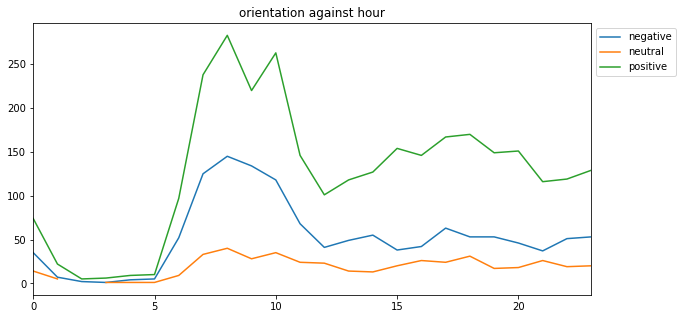

In [125]:
# trump's orientation against hour
# similar trend for all orientation, but he sent more tweets in the morning
hour.plot(kind='line', figsize=(10, 5))
plt.xlabel('')
plt.title('orientation against hour')
plt.legend(bbox_to_anchor=(1,1), loc="upper left")
plt.show()

In [126]:
# trump's orientation against day_of_week
# 1 is Monday, etc
day_of_week = trump.groupby(['day_of_week', 'orientation']).size().unstack()
day_of_week

orientation,negative,neutral,positive
day_of_week,,,
1,193,50,420
2,163,54,483
3,186,83,468
4,187,78,449
5,170,69,469
6,157,55,378
7,221,53,353


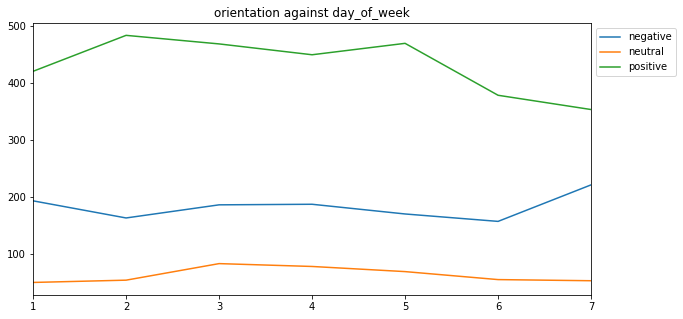

In [128]:
# trump's orientation against day_of_week
# 1 is Monday, etc
# it seems when trump sent more positive tweets on a day, he trent to send less negative tweets on the same day
# except on Saturday, amounts of both positive and negative tweets were decreasing
day_of_week.plot(kind='line', figsize=(10, 5))
plt.xlabel('')
plt.title('orientation against day_of_week')
plt.legend(bbox_to_anchor=(1,1), loc="upper left")
plt.show()

In [129]:
# trump's orientation against month
trump['month_text'] = trump['year'].astype(str) + '-' + trump['month'].astype(str).str.pad(side='left', 
                                                                                           fillchar='0', width=2) 
month_text = trump.groupby(['month_text', 'orientation']).size().unstack()
month_text

orientation,negative,neutral,positive
month_text,,,
2019-05,113,22,238
2019-06,85,16,213
2019-07,123,28,301
2019-08,109,19,283
2019-09,126,39,269
2019-10,161,81,311
2019-11,101,48,214
2019-12,124,52,250
2020-01,90,39,214


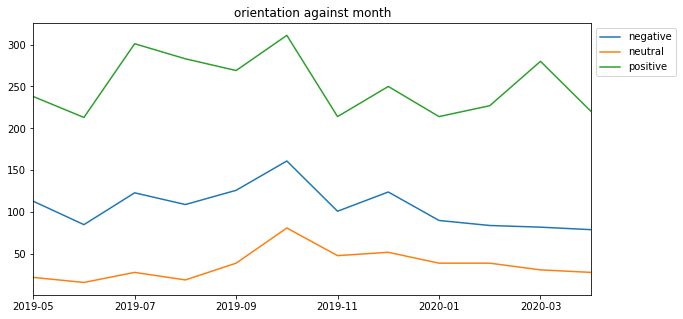

In [131]:
# trump's orientation against month
# similar trends of all orientation in all months
# except in 2020-03, there was an increase of amount of positive tweets, 
# but amount of negative and neutral tweets didn't change a lot
month_text.plot(kind='line', figsize=(10, 5))
plt.xlabel('')
plt.title('orientation against month')
plt.legend(bbox_to_anchor=(1,1), loc="upper left")
plt.show()

### retweet_count

In [132]:
# average retweet_count against hour
hour = trump.groupby(['hour', 'orientation'])['retweet_count'].mean().unstack()
hour

orientation,negative,neutral,positive
hour,,,
0,21307.971429,15371.571429,18657.986486
1,18781.000000,16440.200000,18914.045455
2,17924.000000,NaN,18335.200000
3,41368.000000,13965.000000,17958.000000
4,22058.250000,19889.000000,12000.111111
5,18507.200000,12249.000000,17881.600000
6,18405.461538,17334.777778,18104.525773
7,20203.184000,19682.424242,16972.399160
8,21108.758621,20145.375000,18384.985866


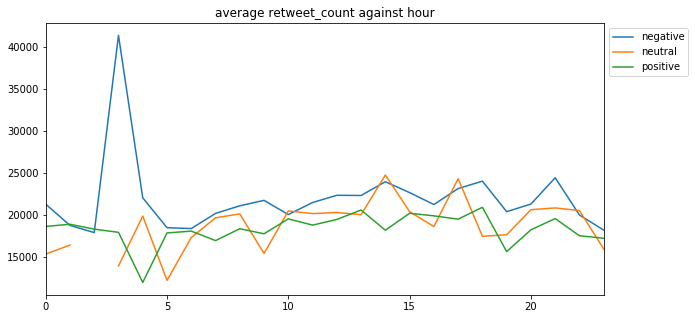

In [133]:
# average retweet_count against hour
# there were more retweets of trump's negative tweets in the midnight
hour.plot(kind='line', figsize=(10, 5))
plt.xlabel('')
plt.title('average retweet_count against hour')
plt.legend(bbox_to_anchor=(1,1), loc="upper left")
plt.show()

In [134]:
# average retweet_count against day_of_week
# 1 is Monday, etc
day_of_week = trump.groupby(['day_of_week', 'orientation'])['retweet_count'].mean().unstack()
day_of_week

orientation,negative,neutral,positive
day_of_week,,,
1,22076.062176,20564.600000,18892.578571
2,19543.380368,15680.148148,18601.538302
3,20896.010753,21125.036145,18283.209402
4,22322.743316,17478.666667,17496.331849
5,20320.970588,21146.869565,18602.251599
6,21897.585987,22959.290909,18645.206349
7,21695.298643,16769.603774,20425.903683


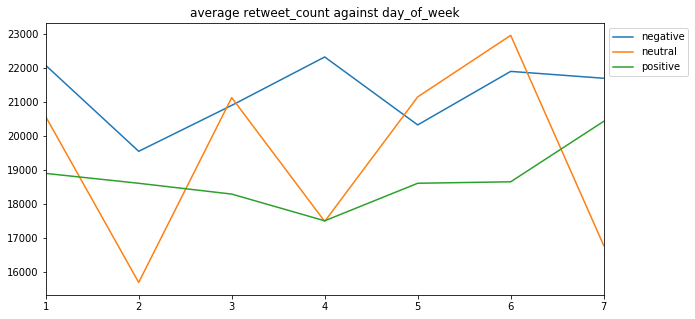

In [135]:
# average retweet_count against day_of_week
# 1 is Monday, etc
day_of_week.plot(kind='line', figsize=(10, 5))
plt.xlabel('')
plt.title('average retweet_count against day_of_week')
plt.legend(bbox_to_anchor=(1,1), loc="upper left")
plt.show()

In [136]:
# average retweet_count against month
trump['month_text'] = trump['year'].astype(str) + '-' + trump['month'].astype(str).str.pad(side='left', 
                                                                                           fillchar='0', width=2) 
month_text = trump.groupby(['month_text', 'orientation'])['retweet_count'].mean().unstack()
month_text

orientation,negative,neutral,positive
month_text,,,
2019-05,18731.734513,16092.136364,17906.726891
2019-06,20338.011765,17718.625000,17074.244131
2019-07,22178.593496,17461.607143,18296.036545
2019-08,18682.385321,15876.052632,16400.759717
2019-09,16708.761905,18475.641026,14586.308550
2019-10,19242.571429,20611.617284,17029.485531
2019-11,17521.841584,17312.770833,17111.126168
2019-12,21522.274194,18565.288462,17432.480000
2020-01,24495.944444,20633.589744,23375.313084


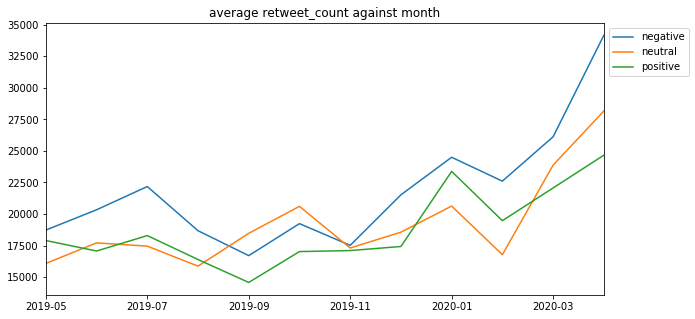

In [137]:
# average retweet_count against month
# there was an increase of retweets in 2020-04
month_text.plot(kind='line', figsize=(10, 5))
plt.xlabel('')
plt.title('average retweet_count against month')
plt.legend(bbox_to_anchor=(1,1), loc="upper left")
plt.show()

### favorite_count

In [138]:
# average favorite_count against hour
hour = trump.groupby(['hour', 'orientation'])['favorite_count'].mean().unstack()
hour

orientation,negative,neutral,positive
hour,,,
0,91915.000000,55101.714286,87828.581081
1,82990.714286,66822.000000,92140.727273
2,70353.500000,NaN,75769.000000
3,185292.000000,58419.000000,89541.666667
4,91575.250000,100713.000000,58948.111111
5,87012.400000,52913.000000,77847.100000
6,75956.692308,79579.888889,85864.288660
7,87987.656000,99233.454545,80839.218487
8,90574.868966,94791.875000,85945.996466


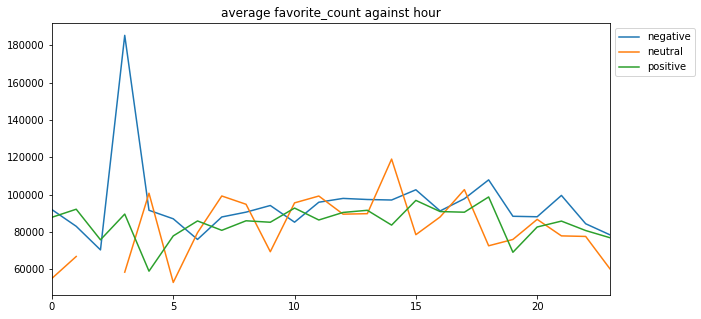

In [139]:
# average favorite_count against hour
# there were more favorites of trump's negative tweets in the midnight
hour.plot(kind='line', figsize=(10, 5))
plt.xlabel('')
plt.title('average favorite_count against hour')
plt.legend(bbox_to_anchor=(1,1), loc="upper left")
plt.show()

In [140]:
# average favorite_count against day_of_week
# 1 is Monday, etc
day_of_week = trump.groupby(['day_of_week', 'orientation'])['favorite_count'].mean().unstack()
day_of_week

orientation,negative,neutral,positive
day_of_week,,,
1,94470.989637,97550.800000,87770.523810
2,84155.766871,70650.500000,85969.244306
3,89746.865591,92620.831325,84280.559829
4,94521.989305,76222.551282,81376.354120
5,86958.076471,89673.695652,83939.055437
6,94951.783439,98630.781818,87446.378307
7,94085.515837,72010.622642,97691.628895


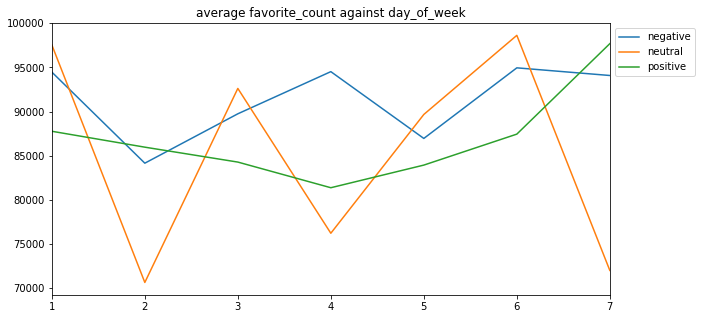

In [141]:
# average favorite_count against day_of_week
# 1 is Monday, etc
day_of_week.plot(kind='line', figsize=(10, 5))
plt.xlabel('')
plt.title('average favorite_count against day_of_week')
plt.legend(bbox_to_anchor=(1,1), loc="upper left")
plt.show()

In [142]:
# average favorite_count against month
trump['month_text'] = trump['year'].astype(str) + '-' + trump['month'].astype(str).str.pad(side='left', 
                                                                                           fillchar='0', width=2) 
month_text = trump.groupby(['month_text', 'orientation'])['favorite_count'].mean().unstack()
month_text

orientation,negative,neutral,positive
month_text,,,
2019-05,80459.778761,69535.136364,81997.584034
2019-06,91358.694118,84501.875000,82201.859155
2019-07,99363.869919,73730.357143,88481.820598
2019-08,83901.862385,68420.052632,75941.731449
2019-09,70040.880952,74341.153846,66439.576208
2019-10,77190.714286,81331.135802,71294.897106
2019-11,70464.237624,71206.750000,74673.233645
2019-12,87625.887097,83916.211538,75877.708000
2020-01,113005.733333,96642.128205,113767.242991


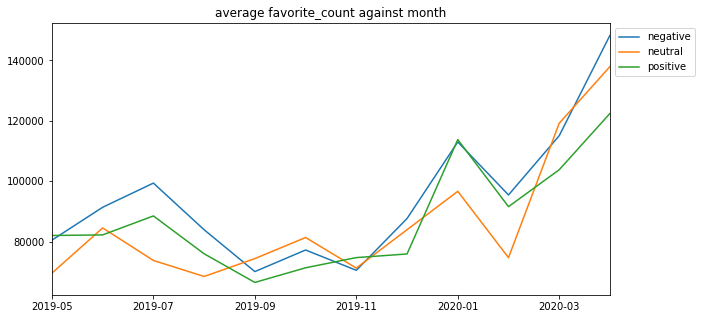

In [143]:
# average favorite_count against month
# there was an increase of favorites in 2020-04
month_text.plot(kind='line', figsize=(10, 5))
plt.xlabel('')
plt.title('average favorite_count against month')
plt.legend(bbox_to_anchor=(1,1), loc="upper left")
plt.show()